
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

## Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling

In [1]:
import pandas as pd 
import geopandas as gpd
from glob import glob
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='pyproj')
warnings.filterwarnings(action='ignore', category=FutureWarning, module='sklearn')
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import eli5
from eli5.sklearn import PermutationImportance
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import plotly.graph_objs as go
import shap


In [2]:
def crop_trips_by_coordinates(dataframe):
    dataframe = dataframe[dataframe["start_lat"] > 33].copy()
    dataframe = dataframe[dataframe["end_lat"] > 33].copy()
    dataframe = dataframe[dataframe["start_lon"] < -116].copy()
    dataframe = dataframe[dataframe["end_lon"] < -116].copy()
    return dataframe

def generate_datetime_features(dataframe):
    dataframe["start_time"] = pd.to_datetime(dataframe["start_time"])
    dataframe["end_time"] = pd.to_datetime(dataframe["end_time"])
    dataframe["trip_duration_in_minutes"] = dataframe["end_time"] - dataframe["start_time"]
    df = dataframe[dataframe["trip_duration_in_minutes"] > pd.Timedelta(minutes=0)].copy()
    df = df[df["trip_duration_in_minutes"] < pd.Timedelta(hours=24)]
    df["trip_duration_in_minutes"] = df["trip_duration_in_minutes"] / pd.Timedelta(minutes=1)
    df["year"] = df["start_time"].dt.year
    df["month"] = df["start_time"].dt.month
    df["day_of_week"] = df["start_time"].dt.dayofweek
    df["hour"] = df["start_time"].dt.hour
    df = df.sort_values("start_time")
    return df

def add_coordinate_features(dataframe):
    df = dataframe.copy()
    df['StartCoordinate'] = list(zip(df.start_lat, df.start_lon))
    df['EndCoordinate'] = list(zip(df.end_lat, df.end_lon))
    return df

def engineer_data(dataframe):
    # Copy input DataFrame
    engineered_data = dataframe.copy()
    # Apply coarse spatial filter based on coordinates
    engineered_data = crop_trips_by_coordinates(engineered_data)
    # Remove duplicate trips
    engineered_data.drop_duplicates(["trip_id"], inplace=True)
    # Generate datetime features such as trip day of week and hour of day
    engineered_data = generate_datetime_features(engineered_data)
    # Crop unneccessary columns
    engineered_data = engineered_data[["trip_id","start_time","end_time","start_lat","start_lon","end_lat","end_lon","bike_id","trip_route_category","passholder_type","trip_duration_in_minutes","year","month","day_of_week","hour"]].copy()
    # Dictionary to map Los Angeles user classes to simplified "Customer" vs. "Subscriber" dichotomy
    simplified_dictionary = {"Annual Pass": "Subscriber", 
                             "Flex Pass":"Subscriber", 
                             "Monthly Pass": "Subscriber", 
                             "One Day Pass": "Customer", 
                             "Walk-up":"Customer"}
    engineered_data["UserType"] = engineered_data["passholder_type"].map(simplified_dictionary)
    engineered_data['DayType'] = engineered_data['day_of_week'].apply(lambda x: 'Weekday' if x <= 4 else 'Weekend')
    return engineered_data

def merge_trips_with_ancillary_data(dataframe):
    
    starts_gdf = gpd.GeoDataFrame(dataframe.drop(["end_lon","end_lat"], axis=1), geometry=gpd.points_from_xy(dataframe.start_lon, dataframe.start_lat))
    ends_gdf = gpd.GeoDataFrame(dataframe.drop(["start_lon","start_lat"], axis=1), geometry=gpd.points_from_xy(dataframe.end_lon, dataframe.end_lat))
    
    starts_gdf.crs = "EPSG:4326"
    ends_gdf.crs = "EPSG:4326"
    
    census_places = "http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/census-places-2012.geojson"
    census_tracts = "http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/census-tracts-2012.geojson"
    neighborhoods = "http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/la-county-neighborhoods-current.geojson"
    regions = "http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/la-county-regions-current.geojson"

    census_places_gdf = gpd.read_file(census_places)
    census_tracts_gdf = gpd.read_file(census_tracts)
    neighborhoods_gdf = gpd.read_file(neighborhoods)
    regions_gdf = gpd.read_file(regions)
    
    census_places_gdf = census_places_gdf.to_crs("EPSG:4326")
    census_tracts_gdf = census_tracts_gdf.to_crs("EPSG:4326")
    neighborhoods_gdf = neighborhoods_gdf.to_crs("EPSG:4326")
    regions_gdf = regions_gdf.to_crs("EPSG:4326")
    
    census_places_gdf = census_places_gdf.drop(["kind","external_id","slug","set","metadata","resource_uri"], axis=1)
    census_places_gdf.rename(columns={"name":"CensusPlace"}, inplace=True)
    
    census_tracts_gdf = census_tracts_gdf.drop(["kind","external_id","slug","set","metadata","resource_uri"], axis=1)
    census_tracts_gdf.rename(columns={"name":"CensusTract"}, inplace=True)
    
    neighborhoods_gdf.drop(["kind","external_id","slug","set","metadata","resource_uri"], axis=1, inplace=True)
    neighborhoods_gdf.rename(columns={"name":"Neighborhood"}, inplace=True)

    regions_gdf.drop(["kind","external_id","slug","set","metadata","resource_uri"], axis=1, inplace=True)
    regions_gdf.rename(columns={"name":"Region"}, inplace=True)

    starts_census_tracts_gdf = gpd.sjoin(starts_gdf, census_tracts_gdf, how="left")
    starts_census_places_gdf = gpd.sjoin(starts_gdf, census_places_gdf, how="left")
    starts_neighborhoods_gdf = gpd.sjoin(starts_gdf, neighborhoods_gdf, how="left")
    starts_regions_gdf = gpd.sjoin(starts_gdf, regions_gdf, how="left")
    
    starts_regions_gdf.drop(["index_right"], axis=1, inplace=True)
    starts_neighborhoods_gdf.drop(["index_right"], axis=1, inplace=True)
    starts_census_places_gdf.drop(["index_right"], axis=1, inplace=True)
    starts_census_tracts_gdf.drop(["index_right"], axis=1, inplace=True)
    
    ends_census_tracts_gdf = gpd.sjoin(ends_gdf, census_tracts_gdf, how="left")
    ends_census_places_gdf = gpd.sjoin(ends_gdf, census_places_gdf, how="left")
    ends_neighborhoods_gdf = gpd.sjoin(ends_gdf, neighborhoods_gdf, how="left")
    ends_regions_gdf = gpd.sjoin(ends_gdf, regions_gdf, how="left")
    
    ends_regions_gdf.drop(["index_right"], axis=1, inplace=True)
    ends_neighborhoods_gdf.drop(["index_right"], axis=1, inplace=True)
    ends_census_places_gdf.drop(["index_right"], axis=1, inplace=True)
    ends_census_tracts_gdf.drop(["index_right"], axis=1, inplace=True)
    
    starts_with_boundaries = starts_regions_gdf.merge(starts_neighborhoods_gdf[["trip_id","Neighborhood"]], on="trip_id").merge(starts_census_places_gdf[["trip_id","CensusPlace"]], on="trip_id").merge(starts_census_tracts_gdf[["trip_id","CensusTract"]], on="trip_id")
    ends_with_boundaries = ends_regions_gdf.merge(ends_neighborhoods_gdf[["trip_id","Neighborhood"]], on="trip_id").merge(ends_census_places_gdf[["trip_id","CensusPlace"]], on="trip_id").merge(ends_census_tracts_gdf[["trip_id","CensusTract"]], on="trip_id")
    
    starts_with_boundaries_df = pd.DataFrame(starts_with_boundaries.drop(["geometry"], axis=1))
    ends_with_boundaries_df = pd.DataFrame(ends_with_boundaries[["trip_id","Region","Neighborhood","CensusPlace","CensusTract"]])
    
    trips_with_boundaries_df = starts_with_boundaries_df.merge(ends_with_boundaries_df, on="trip_id", suffixes=("_start","_end"))
        
    return trips_with_boundaries_df

In [3]:
# Use wildcard to read-in all csv files in folder
filepath = glob("/home/alex/data/la-metro-bike-share/*.csv")

# Use low memory option to avoid specifying datatypes explicitly
dataframes = [pd.read_csv(f, low_memory=False) for f in filepath]

# Concatenate each individual CSV dataframe into a single dataframe
df = pd.concat(dataframes)

# Engineer data
trip_data = engineer_data(df)

# Merge trip data with ancillary boundary data
trips_with_boundaries = merge_trips_with_ancillary_data(trip_data)

# Engineer a new feature
trips_with_boundaries["Stays in same CensusTract"] = trips_with_boundaries["CensusTract_start"] == trips_with_boundaries["CensusTract_end"]

# Return distribution of engineered feature
trips_with_boundaries["Stays in same CensusTract"].value_counts(normalize=True)*100

False    74.297108
True     25.702892
Name: Stays in same CensusTract, dtype: float64

In [4]:
data_for_predictions = trips_with_boundaries.drop(["trip_id","start_time","end_time","trip_duration_in_minutes","bike_id", "trip_route_category","Region_end","Neighborhood_end","CensusPlace_end","CensusTract_end"], axis=1)

data_for_predictions.head()

start_lat  start_lon passholder_type  year  month  day_of_week  hour  \
0  34.056610 -118.23721    Monthly Pass  2016      7            3     4   
1  34.056610 -118.23721    Monthly Pass  2016      7            3     6   
2  34.052898 -118.24156       Flex Pass  2016      7            3    10   
3  34.052898 -118.24156       Flex Pass  2016      7            3    10   
4  34.049889 -118.25588         Walk-up  2016      7            3    12   

     UserType  DayType  Region_start Neighborhood_start CensusPlace_start  \
0  Subscriber  Weekday  Central L.A.           Downtown       Los Angeles   
1  Subscriber  Weekday  Central L.A.           Downtown       Los Angeles   
2  Subscriber  Weekday  Central L.A.           Downtown       Los Angeles   
3  Subscriber  Weekday  Central L.A.           Downtown       Los Angeles   
4    Customer  Weekday  Central L.A.           Downtown       Los Angeles   

  CensusTract_start  Stays in same CensusTract  
0       06037206020                       True  
1       06037206020                       True  
2       06037207400                       True  
3       06037207400                       True  
4       06037207710                       True

In [5]:
train, test = train_test_split(
    data_for_predictions, 
    train_size=0.80, 
    test_size=0.20, 
    random_state=42)

train, validate = train_test_split(
    train, 
    train_size=0.80, 
    test_size=0.20, 
    random_state=42)

train.shape, validate.shape, test.shape


((579503, 14), (144876, 14), (181095, 14))

In [6]:
# The status_group column is the target
target = 'Stays in same CensusTract'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality.index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
features

['start_lat',
 'start_lon',
 'year',
 'month',
 'day_of_week',
 'hour',
 'passholder_type',
 'UserType',
 'DayType',
 'Region_start',
 'Neighborhood_start',
 'CensusPlace_start',
 'CensusTract_start']

In [7]:
y_train = train[target]
y_validate = validate[target]
y_test = test[target]

majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

print("\n",classification_report(y_train, y_pred))


               precision    recall  f1-score   support

       False       0.74      1.00      0.85    430750
        True       0.00      0.00      0.00    148753

    accuracy                           0.74    579503
   macro avg       0.37      0.50      0.43    579503
weighted avg       0.55      0.74      0.63    579503



In [8]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_validate = validate[features]
y_validate = validate[target]
X_test = test[features]
y_test = test[target]

In [9]:
scale_pos_weight = train["Stays in same CensusTract"].value_counts(normalize=True)[0] / train["Stays in same CensusTract"].value_counts(normalize=True)[1]

transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_validate_transformed = transformers.transform(X_validate)

model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, scale_pos_weight=scale_pos_weight)

model.fit(X_train_transformed, y_train)

permuter = PermutationImportance(
    model, 
    scoring="accuracy", 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_validate_transformed, y_validate)

feature_names = X_validate.columns.tolist()

eli5.show_weights(permuter, top=None, feature_names=feature_names)

In [10]:
minimum_importance = 0

mask = permuter.feature_importances_ > minimum_importance

permuted_features = X_train.columns[mask]

permuted_features

Index(['start_lat', 'start_lon', 'month', 'day_of_week', 'hour', 'UserType',
       'Neighborhood_start'],
      dtype='object')

In [11]:
X_train_permuted = X_train[permuted_features]
X_validate_permuted = X_validate[permuted_features]

In [12]:

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(
        n_estimators=100, 
        random_state=42, 
        n_jobs=-1, 
        scale_pos_weight=scale_pos_weight
    )
)

pipeline.fit(
    X_train_permuted, 
    y_train
)

y_pred = pipeline.predict(
    X_validate_permuted
)

print(
    "\n",
    classification_report(
          y_validate, 
          y_pred
    )
)


               precision    recall  f1-score   support

       False       0.85      0.66      0.75    107454
        True       0.41      0.67      0.51     37422

    accuracy                           0.67    144876
   macro avg       0.63      0.67      0.63    144876
weighted avg       0.74      0.67      0.68    144876



## Make at least 1 partial dependence plot to explain your model.

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f35b3b12cd0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f35b397e0d0>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


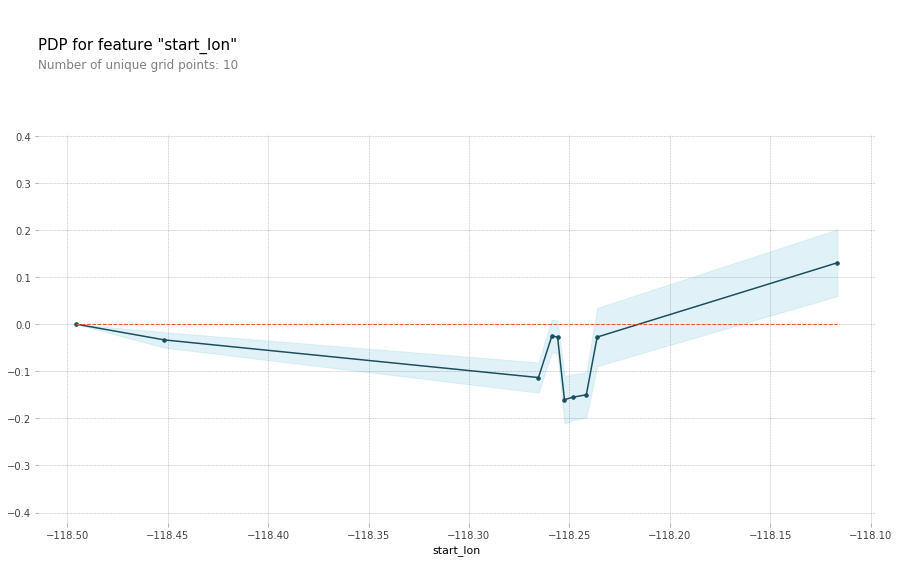

In [19]:
feature = "start_lon"

isolate = pdp_isolate(
    model = pipeline,
    dataset = X_validate_permuted,
    model_features = X_validate_permuted.columns,
    feature = feature  

)
pdp_plot(isolate, feature_name=feature)

(-118.28, -118.22)

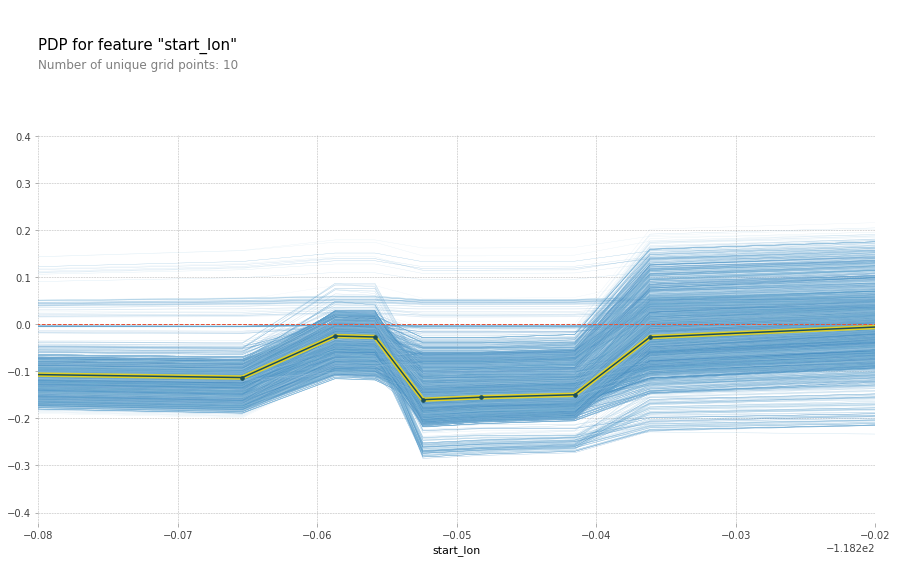

In [21]:
pdp_plot(isolate, feature_name=feature, plot_lines=True, frac_to_plot=0.05)
plt.xlim(-118.28,-118.22)

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f35d66c7990>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f35d66c2d10>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


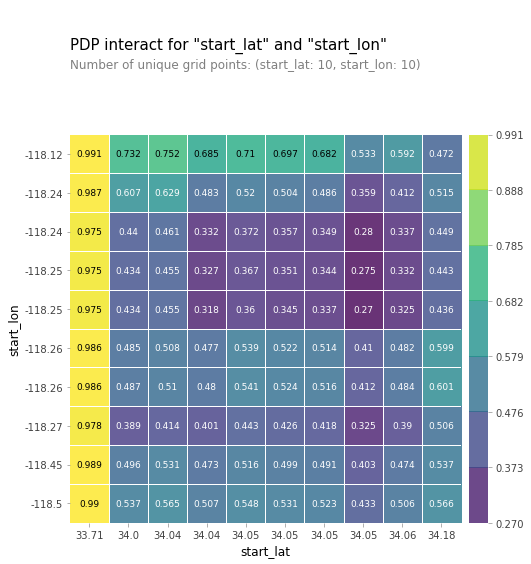

In [22]:

features = ["start_lat", "start_lon"]

interaction = pdp_interact(model=pipeline, dataset=X_validate_permuted, model_features=X_validate_permuted.columns, features=features)

pdp_interact_plot(interaction, plot_type="grid", feature_names=features)

In [23]:
# First, make the 2D plot above. Then ...

pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]
)[::-1] # Slice notation to reverse index order so y axis is ascending

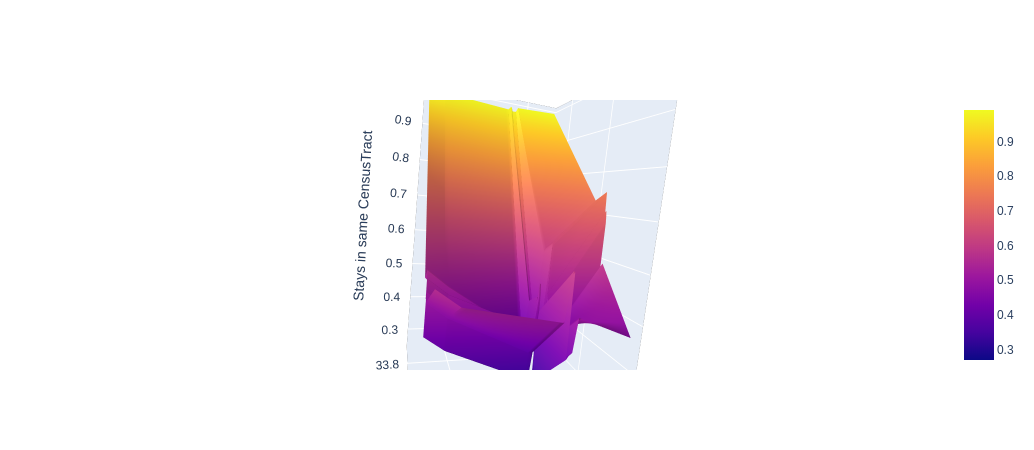

In [24]:
import plotly.graph_objs as go

surface = go.Surface(
    x=pdp.columns, 
    y=pdp.index, 
    z=pdp.values
)


layout = go.Layout(
    scene=dict(
        xaxis=dict(title=features[0]), 
        yaxis=dict(title=features[1]), 
        zaxis=dict(title=target)
    )
)

fig = go.Figure(surface, layout)
fig.show()

In [24]:
row = X_test.iloc[[20000]]

transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'))


explainer = shap.TreeExplainer(model)
row_processed = transformers.fit_transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()

shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # For classification, this shows predicted probabilities
)

In [27]:
feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
shaps

(start_lat, 33.984341)              0.236586
(start_lon, -118.47155)             0.061468
(year, 2018)                       -0.025439
(month, 12)                         0.002398
(day_of_week, 4)                   -0.013858
(hour, 12)                          0.040579
(passholder_type, Walk-up)         -0.020676
(UserType, Customer)               -0.306987
(DayType, Weekday)                  0.000000
(Region_start, Westside)           -0.002258
(Neighborhood_start, Venice)        0.000798
(CensusPlace_start, Los Angeles)    0.000000
(CensusTract_start, 06037273502)   -0.093193
dtype: float32

In [25]:
pros = shaps.sort_values(ascending=False)[:3].index
cons = shaps.sort_values(ascending=True)[:3].index

In [26]:
print('Top 3 reasons for going to other Census Tract:')
for i, pro in enumerate(pros, start=1):
    feature_name, feature_value = pro
    print(f'{i}. {feature_name} is {feature_value}.')

print('\n')
print('Cons:')
for i, con in enumerate(cons, start=1):
    feature_name, feature_value = con
    print(f'{i}. {feature_name} is {feature_value}.')

Top 3 reasons for going to other Census Tract:
1. start_lon is -118.14906299999998.
2. passholder_type is Monthly Pass.
3. month is 7.


Cons:
1. UserType is Subscriber.
2. start_lat is 34.14175.
3. day_of_week is 4.
